## BC205 Final Project: Maximal coverage of valued elements
---

#####  **Author:** Georgios Kousis Tsampazis
---

### Overview
**Maximal coverage of valued elements**. (Genomics, Epigenomics) \
   **Background**: Very often in the fields of genomics and epigenomics we are dealing with a set of genomic coordinates of segments defined through an experimental protocol that we wish to map on the genome in an objective way. Such segments may be overlapping regions of different TF-binding sites or nucleosome positions. In this project, you are asked to provide a strategy to distribute a subset of non-overlapping genomic segments, starting from a bigger set of overlapping ones, using a pre-assigned score/value to each one.   
   **Details**:  
   Given: a) the total length of a genome (or a chromosome) and b) a set of _overlapping_ segment coordinates from that genome, where each segment is assigned a value(score). Find the set of non-overlapping segments that maximizes the sum of values(scores) for the given genome.
   You are asked to:

   * Obtain [this file](https://www.dropbox.com/scl/fi/t1uvn8xfwavlo6jmt1cx1/sacCer3_chrIV_nucs_overlapping.bed?dl=0&rlkey=vuyfn519sqsp3wnns89nsdlal) which contains overlapping predictions for the positions of >80k nucleosomes in the chromosome IV of S. cerevisiae.
   * Devise a strategy according to which the coordinate segments in the file (that means each row in the file) will be considered on the basis of their score (given in the 4th column)
   * The output should be a **subset** of the original files that will contain the maximum number of non-overlapping segments that sum up to the highest overall score.
   * You can try to compare a greedy approach, with a dynamic programming approach **(BUT! stay away from Brute Force)**
   * Provide the python code that will take the above file as input and return a similar set of non-overlapping coordinates.
### Notebook Instructions 
**Part 1**: Download
   >Download Dependencies and Data

**Part 2**: Preprocessing
   >Open BED and filter out **chr** column

**Part 3**: Solving with Greedy approach
   >Sort by Score \
   >IntervalTree or Suckless approach 

**Part 4**: Solving with Dynamic Programming
   >Bottom-up Approach with binary search

**Part 5**: Greedy vs DP



### **Part 1**: Download

#### Dependencies
*As always a conda enviroment is recommended for easier installation*

In [1]:
pip install --quiet pandas intervaltree tqdm requests matplotlib plotly numpy nbformat upsetplot seaborn

Note: you may need to restart the kernel to use updated packages.


#### Data

In [2]:
import os
import requests
from tqdm import tqdm

# Create the data directory if it doesn't exist.
data_dir = "./.data_tmp/"
os.makedirs(data_dir, exist_ok=True)
files_to_download = {"sacCer3_chrIV_nucs_overlapping.bed": "https://raw.githubusercontent.com/geokousis/Intro-Python/main/sacCer3_chrIV_nucs_overlapping.bed"}

def download_file(url, file_path):
    response = requests.get(url, stream=True)
    response.raise_for_status()  # Raise an error for bad status codes.
    
    total_size = int(response.headers.get('content-length', 0))
    block_size = 1024  # 1 Kilobyte blocks

    with open(file_path, 'wb') as file, tqdm(
            total=total_size, unit='B', unit_scale=True, desc=os.path.basename(file_path)
        ) as progress_bar:
        for data in response.iter_content(block_size):
            file.write(data)
            progress_bar.update(len(data))

for filename, url in files_to_download.items():
    file_path = os.path.join(data_dir, filename)
    if not os.path.exists(file_path):
        print(f"Downloading {filename} ...")
        try:
            download_file(url, file_path)
            print(f"{filename} downloaded successfully.")
        except Exception as e:
            print(f"Error downloading {filename}: {e}")
    else:
        print(f"{filename} already exists. Skipping download.")
print("Files are ready.")


sacCer3_chrIV_nucs_overlapping.bed already exists. Skipping download.
Files are ready.


#### Global imports

In [3]:
import pandas as pd 

### **Part 2**: Preprocessing

#### Open BED

In [4]:
def bed_reader(file_path):
    """
    Reads a BED file and returns a DataFrame (pandas).
    !!! This function assumes the BED file is tab-separated and does not have a header. Also expects the bed file to have 4 columns (Chr,Start,End,Score).
    Parameters:
    file_path (str): Path to the BED file.
    
    Returns:
    pd.DataFrame: DataFrame containing the BED data.
    """
    import pandas as pd # reimporting to ensure it's available in the function scope
    bed = pd.read_csv(file_path, sep='\t', header=None, comment='#', dtype=str)
    bed.rename(columns={0: 'chr', 1: 'start', 2: 'end', 3: 'score'}, inplace=True)
    
    # Convert 'start' and 'end' to integers, and 'score' to float
    bed['start'] = bed['start'].astype(int)
    bed['end'] = bed['end'].astype(int)
    bed['score'] = bed['score'].astype(float)
    
    return bed

In [5]:
bed_with_chr=bed_reader(".data_tmp/sacCer3_chrIV_nucs_overlapping.bed")
chr_length = bed_with_chr.end.max()
print(f"Chromosome length: {chr_length}")
bed_with_chr

Chromosome length: 1531844


,chr,start,end,score
0,chrIV,33,179,0.498429
1,chrIV,47,193,0.771993
2,chrIV,56,202,0.110679
3,chrIV,66,212,0.053812
4,chrIV,72,218,0.028605
...,...,...,...,...
82561,chrIV,1531637,1531783,0.243578
82562,chrIV,1531639,1531785,1.121541
82563,chrIV,1531664,1531810,0.097952
82564,chrIV,1531681,1531827,0.012911


#### Filter out chromosome column

In [6]:
# In this scope chr Column is redudant, so we can drop it
cerevisiae = bed_with_chr.loc[:, bed_with_chr.columns !="chr"]

##### Cerevisiae's BED file

In [7]:
cerevisiae

,start,end,score
0,33,179,0.498429
1,47,193,0.771993
2,56,202,0.110679
3,66,212,0.053812
4,72,218,0.028605
...,...,...,...
82561,1531637,1531783,0.243578
82562,1531639,1531785,1.121541
82563,1531664,1531810,0.097952
82564,1531681,1531827,0.012911


### **Part 3**: Solving with Greedy approach
1. **Sort the intervals**

   * Order by descending **score** (so highest-score first), then ascending **start**, then ascending **end** (for deterministic ties).

2. **Select non-overlapping intervals**

   * **If `suckless=True` <u>(no extra libraries)</u>:**

     * Maintain a list of occupied ranges.
     * For each interval in sorted order:

       * Check against each occupied range to see if it overlaps.
       * If it doesn’t overlap anything, adds it to selection and mark its range occupied.
   * **Otherwise (using `IntervalTree`):**

     * For each interval in sorted order:

       * Check the tree if this interval overlaps any already-added one.
       * If not, insert it into the tree and add it to your selection.

3. **Finalize the result**
    * Sort selected intervals by start.
    * Return the resulting DataFrame.


In [8]:
def greedy(df, suckless=False):
    """
    Selects non-overlapping intervals from a DataFrame using a greedy algorithm.
    By default, uses an efficient implementation with IntervalTree (requires external library).
    
    If `suckless=True`, uses a simpler, dependency-free version.

    Parameters:
    df (pd.DataFrame): DataFrame containing 'start', 'end', and 'score' columns.
    suckless (bool): If True, use the minimal, no-dependency implementation.

    Returns:
    pd.DataFrame: Selected non-overlapping intervals, sorted by start.
    """
    
    import pandas as pd
    from intervaltree import IntervalTree

    required_cols = {'start', 'end', 'score'}
    if not required_cols.issubset(df.columns):
        raise ValueError(f"DataFrame must contain columns: {required_cols}")
    
    if df.empty:
        return pd.DataFrame(columns=['start', 'end', 'score'])
    df_sorted = (
        df
        .sort_values(
            by=["score", "start", "end"], # Sort by score, then start and end.  Score sorting is in the scope of the problem, start/end ensures deterministic behavior (tie breakers).
            ascending=[False, True, True]
        )
        .reset_index(drop=True)
    )

    if suckless:
        # Simple, no-dependency greedy implementation
        selected = []
        occupied = []

        for _, row in df_sorted.iterrows():
            start, end = row["start"], row["end"]

            # Check for overlap
            overlap = False
            for s, e in occupied:
                if not (end <= s or start >= e):
                    overlap = True
                    break

            if not overlap:
                selected.append(row)
                occupied.append((start, end))
    else:
        # Fast IntervalTree-based implementation
        selected = []
        tree = IntervalTree()

        for _, row in df_sorted.iterrows():
            s, e = row['start'], row['end']
            if not tree.overlaps(s, e):
                tree.addi(s, e)
                selected.append(row)

    results = pd.DataFrame(selected).sort_values(by="start").reset_index(drop=True)
    results['start'] = results['start'].astype(int)
    results['end'] = results['end'].astype(int)
    return results


In [9]:
result_greedy = greedy(cerevisiae)

In [10]:
result_greedy

,start,end,score
0,33,179,0.498429
1,188,334,0.929945
2,445,591,0.389445
3,763,909,0.226906
4,997,1143,0.466984
...,...,...,...
7582,1531008,1531154,0.445631
7583,1531169,1531315,0.166704
7584,1531317,1531463,0.421084
7585,1531485,1531631,0.094133


In [11]:
result_greedy_suckless = greedy(cerevisiae,suckless=True)

In [12]:
result_greedy_suckless

,start,end,score
0,33,179,0.498429
1,188,334,0.929945
2,445,591,0.389445
3,763,909,0.226906
4,997,1143,0.466984
...,...,...,...
7582,1531008,1531154,0.445631
7583,1531169,1531315,0.166704
7584,1531317,1531463,0.421084
7585,1531485,1531631,0.094133


In [13]:
result_greedy_suckless.equals(result_greedy)

True

In [14]:
Total_greedy_score = result_greedy["score"].astype(float).sum()
print(f"Total greedy approach score: {Total_greedy_score}")
Total_greedy_rows = result_greedy.shape[0]
print(f"Total greedy approach rows: {Total_greedy_rows}")

Total greedy approach score: 3131.8006946411574
Total greedy approach rows: 7587


### **Part 4: Solving with Dynamic Programming**

Found out this is a weighted interval scheduling with a bottom-up DP in $O(n\log n)$ time ([this helped](https://www.youtube.com/watch?v=YeYgfVFMIZ8)):

1. **Sort intervals by end pos.**

2. **Compute the predecessor array $p$.** \
   For each interval $j$, let

   $$
   p[j] = \max\{\,i < j : \text{end}_i \le \text{start}_j\}
   $$

   (or $-1$ if no such $i$ exists).

3. **Define the DP recurrence.**

   $$
   \mathrm{opt}[j]
   = \max\bigl(\mathrm{opt}[j-1],\;\text{score}_j + (\mathrm{opt}[p[j]]\ \text{if }p[j]\neq -1\text{ else }0)\bigr).
   $$

4. **Fill the table bottom-up.** \
   Loop $j=1$ to $n$, computing $\mathrm{opt}[j]$ from $\mathrm{opt}[j-1]$ and $\mathrm{opt}[p[j]]$.

5. **Reconstruct the solution.** \
   Starting at $j=n$ and compare

Because sorting and each binary search take $O(n\log n)$, and filling the DP table and backtracking are each $O(n)$, the overall time complexity is $O(n\log n)$.


In [ ]:
def weighted_interval_scheduling(df):
    """
    Solves the weighted interval scheduling problem using dynamic programming.
    Returns the optimal subset of non-overlapping intervals maximizing total score.

    Parameters:
    df (pd.DataFrame): DataFrame containing 'start', 'end', and 'score' columns.
    Returns:
    pd.DataFrame: Selected non-overlapping intervals, sorted by start.
    """
    from bisect import bisect_right
    required_cols = {'start', 'end', 'score'}
    if not required_cols.issubset(df.columns):
        raise ValueError(f"DataFrame must contain columns: {required_cols}")
    
    if df.empty:
        return pd.DataFrame(columns=['start', 'end', 'score'])
    
    # Sort by end position
    df_sorted = df.sort_values(by="end").reset_index(drop=True)
    # Extract starts and ends
    starts = df_sorted["start"].tolist()
    ends = df_sorted["end"].tolist()
    scores = df_sorted["score"].tolist()
    # Compute predecessors (p helper array)
    p = []
    for i in range(len(df_sorted)):
        # Find the rightmost interval that ends before the current one starts
        p.append(bisect_right(ends, starts[i]) - 1)
    # Initialize DP table
    n = len(df_sorted)
    opt = [0] * (n + 1)
    # Fill the DP table (opt helper array)
    for j in range(1, n + 1):
        opt[j] = max(opt[j - 1], scores[j - 1] + (opt[p[j - 1] + 1] if p[j - 1] != -1 else 0))
    # Reconstruct the solution
    selected = []
    j = n
    while j > 0:
        if opt[j] == opt[j - 1]:
            j -= 1
        else:
            selected.append(df_sorted.iloc[j - 1])
            j = p[j - 1] + 1 if p[j - 1] != -1 else 0
    results = pd.DataFrame(selected).sort_values(by="start").reset_index(drop=True)
    results['start'] = results['start'].astype(int)
    results['end'] = results['end'].astype(int)
    return results

In [16]:
Results_dp = weighted_interval_scheduling(cerevisiae)

In [17]:
Results_dp_Score = Results_dp["score"].astype(float).sum()
print(f"Total dynamic programming approach score: {Results_dp_Score}")
Results_dp_Score_rows = Results_dp.shape[0]
print(f"Total greedy approach rows: {Results_dp_Score_rows}")

Total dynamic programming approach score: 3175.4653488738277
Total greedy approach rows: 7929


### **Part 5: Greedy vs DP**
The greedy algorithm does not reliably find the global optimum, it scored 3,131.80 with 7,587 intervals, whereas the dynamic-programming solution found the true optimum of 3,175.46 by selecting 7,929 intervals. By systematically exploring overlapping subproblems and building up optimal solutions, DP guarantees the global best rather than settling for locally best. 

In [18]:
import numpy as np
import plotly.express as px

# This code creates an interactive heatmap of binary coverage per bin on a chromosome using Plotly.

# 1) Define bins
bin_size = 100
bins = np.arange(0, chr_length + bin_size, bin_size)
n_bins = len(bins) - 1
bin_centers = bins[:-1] + bin_size / 2

# 2) Compute binary coverage per bin
def binary_coverage(df):
    mids = ((df['start'] + df['end']) / 2).values
    idx = np.digitize(mids, bins) - 1
    idx = idx[(idx >= 0) & (idx < n_bins)]
    cov = np.zeros(n_bins)
    cov[np.unique(idx)] = 1
    return cov

cov_dp = binary_coverage(Results_dp)
cov_greedy = binary_coverage(result_greedy)
data = np.vstack([cov_greedy, cov_dp])

# 3) Create interactive Plotly heatmap
fig = px.imshow(
    data,
    x=bin_centers,
    y=["Greedy", "DP"],
    color_continuous_scale="Greys",
    aspect="auto",
    origin="lower",
    labels={"x": "Genomic coordinate (bp)", "y": "Method", "color": "Covered"}
)

fig.update_layout(
    title=f"Interactive binary coverage per {bin_size}-bp bin on chrIV",
    xaxis=dict(tickformat=".0f"),
    yaxis=dict(tickmode="array"),
    coloraxis_showscale=False  # hide colorbar: 0 is white, 1 is black
)

fig.show()


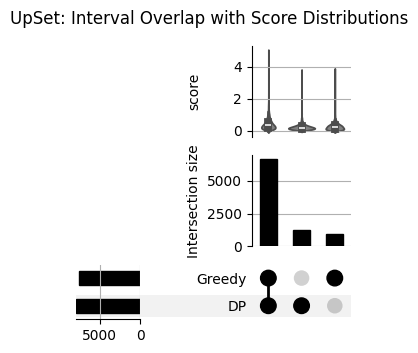

In [20]:
import pandas as pd
from upsetplot import UpSet
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings(
    "ignore",
    message="A value is trying to be set on a copy of a DataFrame or Series through chained assignment.*",
    category=FutureWarning
)

# 1) Map each exact interval to its DP and Greedy scores
dp_map = dict(zip(zip(Results_dp['start'], Results_dp['end']), Results_dp['score']))
gr_map = dict(zip(zip(result_greedy['start'], result_greedy['end']), result_greedy['score']))

# 2) Gather all intervals
all_intervals = sorted(set(dp_map) | set(gr_map))

# 3) Build a DataFrame of indicators + a single 'score' column
records = []
for iv in all_intervals:
    dp_present = iv in dp_map
    gr_present = iv in gr_map
    # choose the score for this iv: prefer DP if present, else Greedy
    score = dp_map[iv] if dp_present else gr_map[iv]
    records.append({
        'DP':       dp_present,
        'Greedy':   gr_present,
        'score':    score
    })

df_up = pd.DataFrame(records).set_index(['DP', 'Greedy'],)

# 4) Create the UpSet plot, showing top 3 intersections
up = UpSet(
    df_up,
    subset_size='count',
    intersection_plot_elements=3,
    sort_by='cardinality'
)

# 5) Add a violin‐style catplot of the 'score' distribution under each bar
up.add_catplot(
    value='score',
    kind='violin',
    color='grey'
)

# 6) Draw it
up.plot()
plt.suptitle("UpSet: Interval Overlap with Score Distributions")
plt.show()


*These two plots show that many positions are covered by both algorithms. You’ll also notice that the score distribution for the greedy method lies slightly above that of the DP approach, a somewhat expected outcome, since greedy always picks the highest‐scoring intervals. However, by focusing only on those high‐score picks, it can miss combinations of lower‐score intervals that together would yield a higher overall total.*


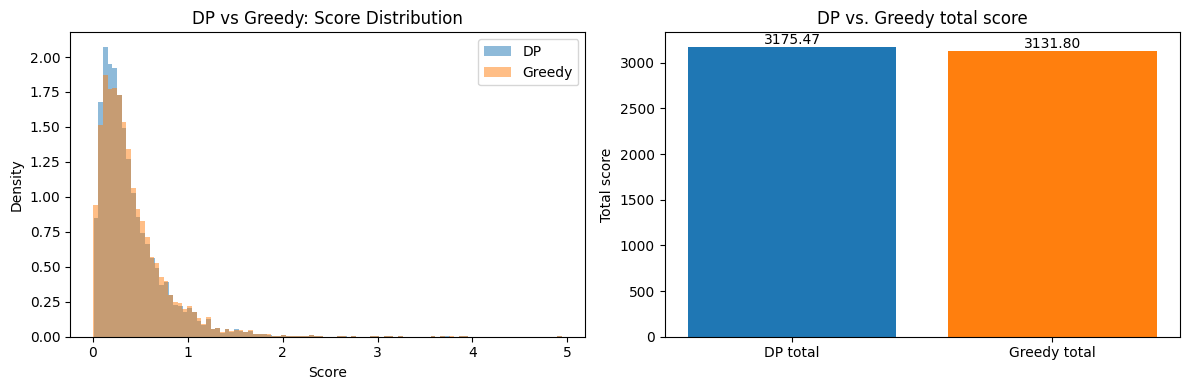

In [21]:
import matplotlib.pyplot as plt

# Compute the total scores if not already variables
dp_total = Results_dp['score'].sum()
greedy_total = result_greedy['score'].sum()

labels = ['DP total', 'Greedy total']
scores = [dp_total, greedy_total]

# Create a figure with 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Rigth: Bar chart
bars = axes[1].bar(labels, scores, color=['C0', 'C1'])
axes[1].set_ylabel('Total score')
axes[1].set_title('DP vs. Greedy total score')
for bar, val in zip(bars, scores):
    axes[1].text(bar.get_x() + bar.get_width()/2, 
                 val + max(scores) * 0.001, f'{val:.2f}',
                 ha='center', va='bottom')

# Left: Overlaid histograms
axes[0].hist(Results_dp['score'], bins=100, density=True, alpha=0.5, label="DP")
axes[0].hist(result_greedy['score'], bins=100, density=True, alpha=0.5, label="Greedy")
axes[0].set_xlabel("Score")
axes[0].set_ylabel("Density")
axes[0].set_title("DP vs Greedy: Score Distribution")
axes[0].legend()

plt.tight_layout()
plt.show()


Once again, the results confirm that the DP method concentrates more intervals in the low-to-mid score ranges while the greedy approach skews toward the highest scores, yet despite this, **the DP solution’s overall total still exceeds that of the greedy algorithm.**

Greedy algorithms are often useful when you need a quick, reasonable solution under specific assumptions. Here, we prioritized the highest individual scores first. Such an approach can serve as a heuristic or an initial approximation for more complex problems. However, if you require a globally optimal solution, you must resort to exhaustive search (brute-forece), which is computationally prohibitive for large inputs, or to dynamic programming. For instance, in the unweighted interval‐scheduling problem, simply sorting by end position  and choosing intervals greedily yields an optimal schedule. But once you introduce weights, only a DP approach can guarantee a truly optimal solution.
